In [1]:
import sys
import gpytorch
import numpy as np
import pandas as pd
import torch
from datetime import datetime
from scipy.stats import qmc
import itertools
from itertools import combinations_with_replacement, combinations, permutations

import bo_methods_lib
from bo_methods_lib.bo_methods_lib.GPBO_Classes_New import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Class_fxns import * #Fix this later
from bo_methods_lib.bo_methods_lib.analyze_data import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Classes_plotters import * #Fix this later
import pympler
import pickle
import signac

from pympler import asizeof

from matplotlib import pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

#Ignore inconcistent version warning
import warnings
# from sklearn.exceptions import InconsistentVersionWarning
# warnings.filterwarnings(action='ignore', category=InconsistentVersionWarning)

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-01 16:07:16.615940: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 16:07:16.615999: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 16:07:16.618094: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-01 16:07:16.629335: I tensorflow/core/platform/cpu_feature_guard

In [2]:
#From signac
import signac
meth_name_val_list = [1, 2, 3, 4, 5, 6, 7]

criteria_dict = {"cs_name_val" : 1,
                 "ep_enum_val": {"$gte": 1},
                 "meth_name_val": {"$in": meth_name_val_list}}

criteria_dict = {"cs_name_val" : 1,
                 "ep_enum_val": 1,
                 "meth_name_val": {"$in": meth_name_val_list}}

criteria_dict = {"cs_name_val" : 2,
                 "gp_package":"gpflow",
                 "meth_name_val": {"$in": [1,2,3,5,6,7]}}
# "param_name_str":{"$exists": False}
project = signac.get_project()
save_csv = False
save_figs = False
analyzer = General_Analysis(criteria_dict, project, save_csv)
plotters = Plotters(analyzer, save_figs)

In [ ]:
plotters.make_parity_plots()

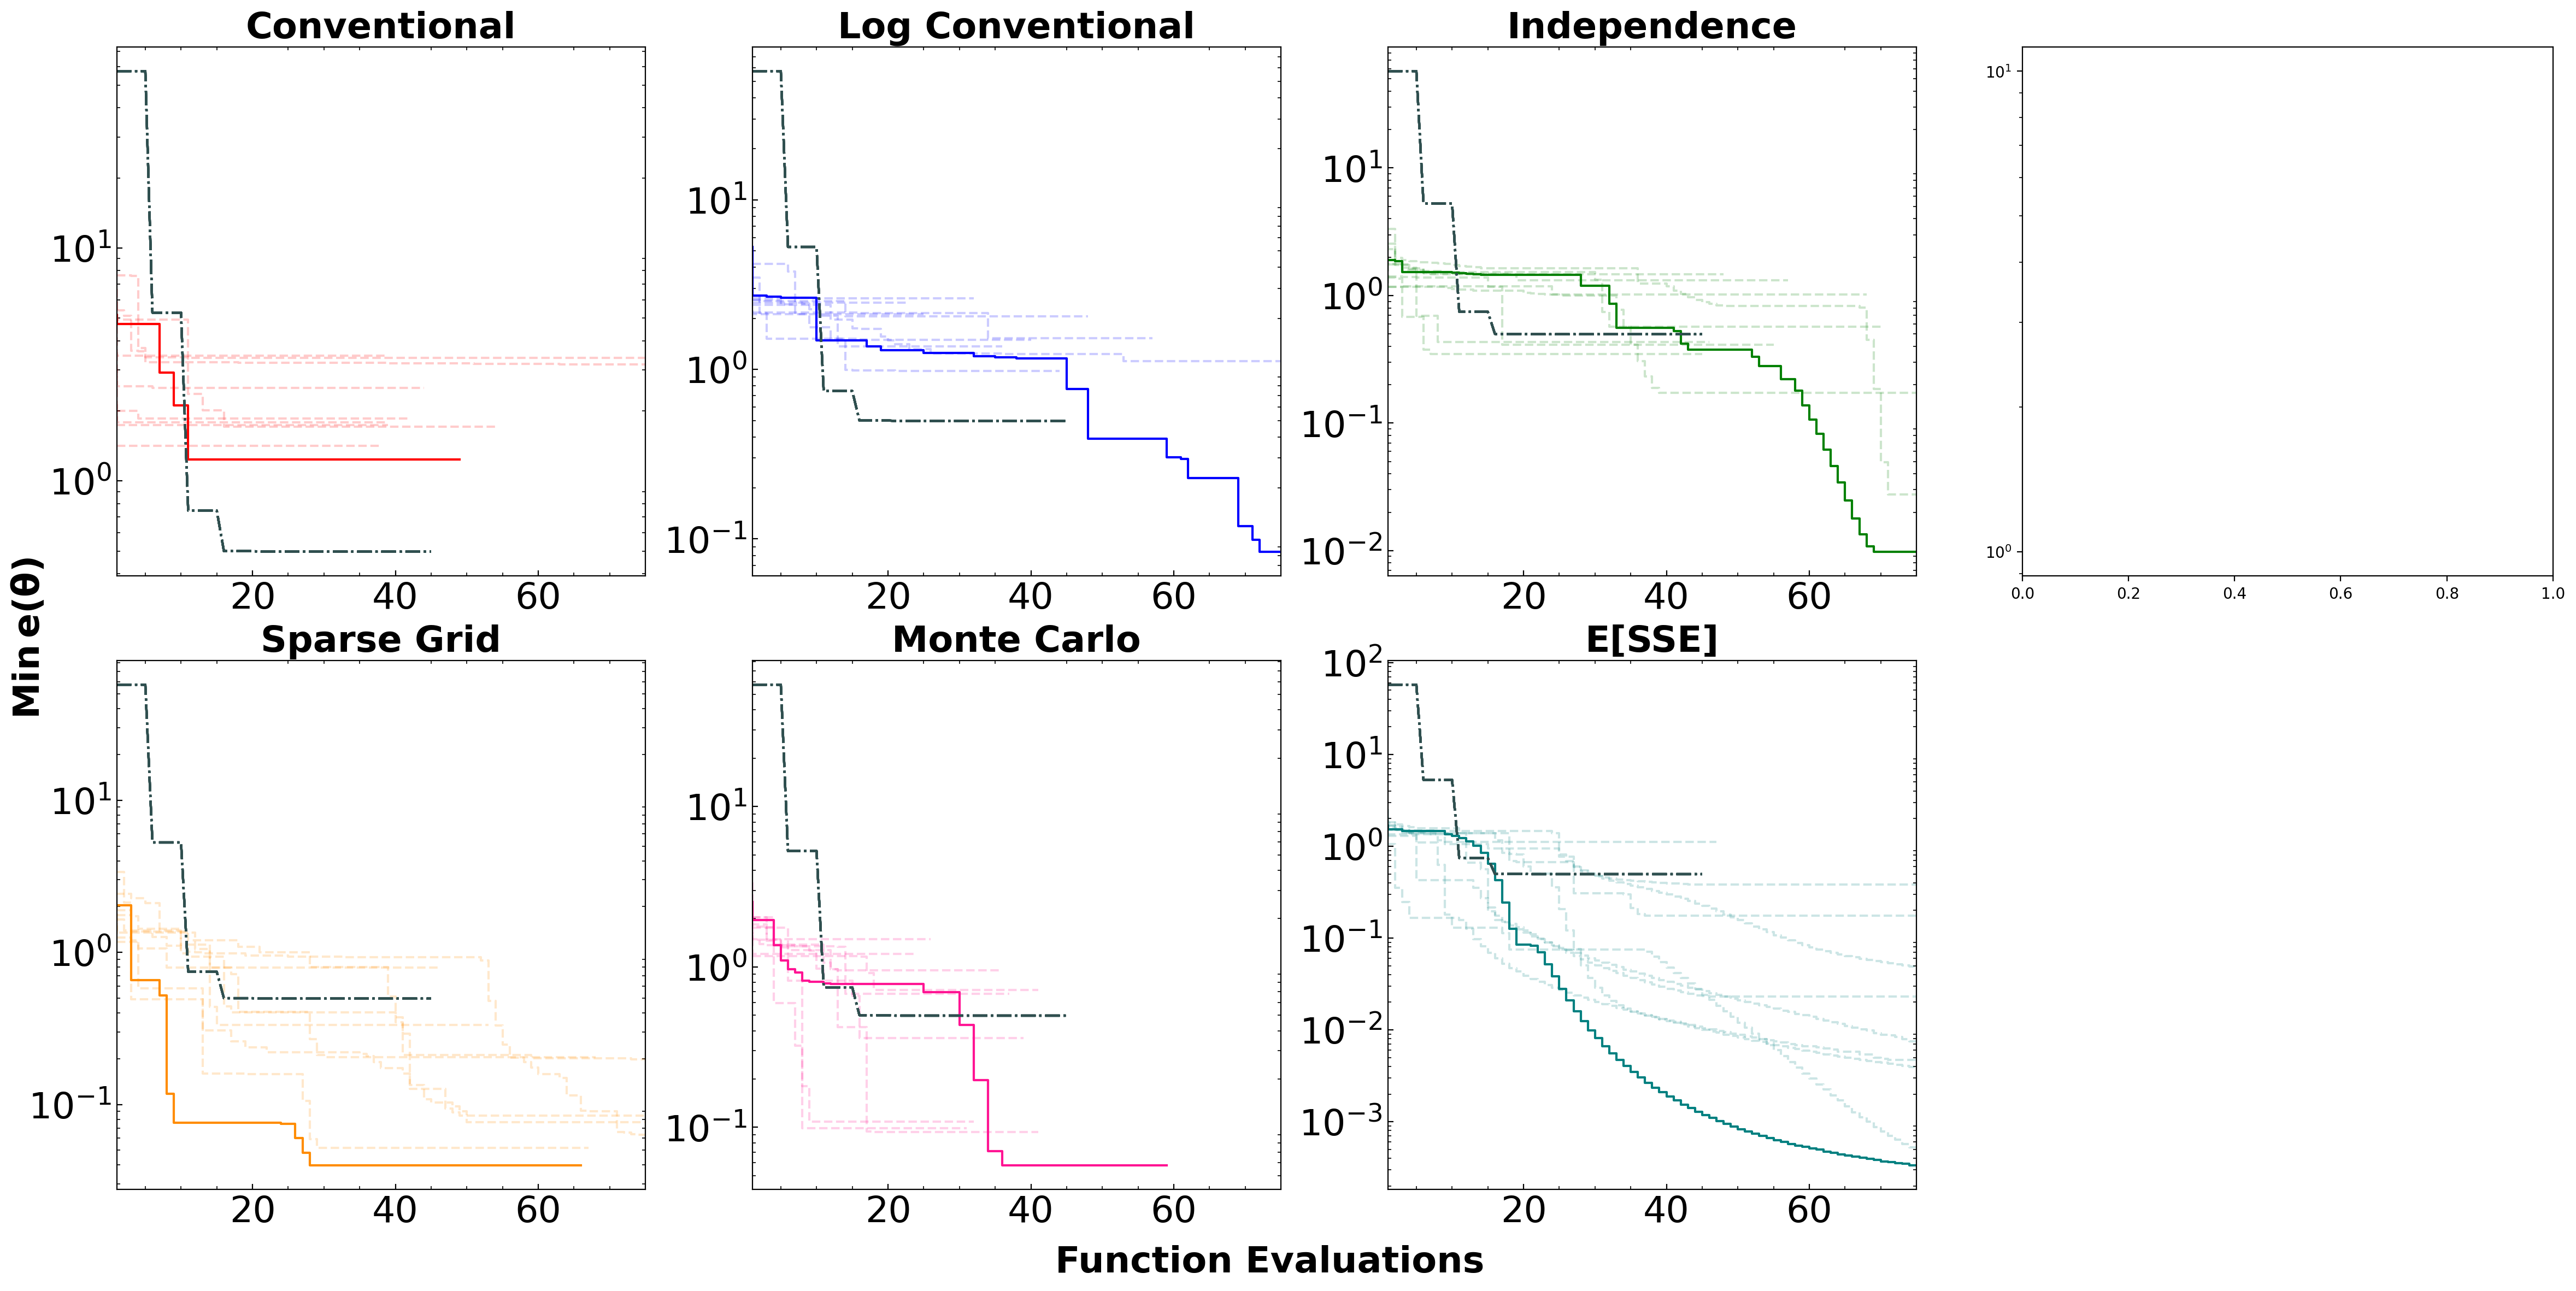

In [3]:
plotters.plot_one_obj_all_methods("min_sse")

In [3]:
# df_all_jobs, job_list, theta_true = analyzer.get_df_all_jobs()
df_best, job_list_best = analyzer.get_best_data()

for i in range(len(job_list_best)): 
    print(job_list_best[i].id)
    
df_best

9dec057b712f563046be720aae51eab8
39d15ad38d790f2d9f9897ed0c7ea587
92ef78754e3de2d34d9e3574e73532f9
e884779e204105155590ad956f0625e3
5c1deeba829f8951c9134c4686136dee
4c900e1d2c62f86bdbf207b503fcdcef


,Run Number,BO Iter,Best Error,Exploration Bias,Opt Acq,Theta Opt Acq,Min Obj,Min Obj Act,Theta Min Obj,Min Obj Cum.,...,Speed,Time/Iter,EP Method Val,MSE,BO Method,Job ID,Max Evals,Termination,Total Run Time,L2 Norm Theta
2138,10,12,1.167370,1.0,2.233835e-01,"[0.7026205494026861, 1.932008218129625, 2.0, -...",1.234750,1.234750,"[0.7027010221843328, 1.931919504084593, 2.0, -...",1.23475,...,0.677889,240.274037,CONSTANT,0.049390,A1,9dec057b712f563046be720aae51eab8,49,obj,11773.427796,3.173809
781,4,73,-1.286190,1.0,1.389086e-01,"[0.9609842351355699, -0.5493638514625685, -0.5...",-2.475270,-2.475270,"[0.9607936762156749, -0.6096700718436598, -0.5...",-2.47527,...,0.019397,406.998169,CONSTANT,0.003366,B1,39d15ad38d790f2d9f9897ed0c7ea587,75,max_budget,30524.862689,0.611368
1713,6,70,0.213231,1.0,1.064082e-01,"[1.0430132699084531, 0.538053547597558, -0.499...",0.009808,0.009808,"[1.0400955110652066, -0.12030099483335593, -0....",0.009808,...,0.541836,2778.574892,CONSTANT,0.000392,A2,92ef78754e3de2d34d9e3574e73532f9,75,max_budget,208393.116921,0.127193
3187,8,29,0.162785,1.0,2.934378e-03,"[0.9630292728716499, 0.3814878988364206, 0.423...",0.039903,0.039903,"[0.8811092637669187, -0.2235334843314809, -0.5...",0.039903,...,0.795997,1959.067415,CONSTANT,0.001596,C2,e884779e204105155590ad956f0625e3,66,obj,129298.449421,0.253246
1076,2,37,0.117452,1.0,1.194689e-08,"[0.8573191866378984, -1.5202848409285943, -0.7...",0.058021,0.058021,"[0.8732262407287374, -0.19868427450286305, -0....",0.058021,...,0.621032,1061.196986,CONSTANT,0.002321,D2,5c1deeba829f8951c9134c4686136dee,59,acq-obj,62610.622186,0.236743
933,1,75,0.000347,1.0,2.968863e-01,"[0.9971602729430026, -0.03068761730840313, -0....",0.000336,0.000336,"[0.9971602729430026, -0.03068761730840313, -0....",0.000336,...,0.491836,2067.670410,CONSTANT,0.000013,A3,4c900e1d2c62f86bdbf207b503fcdcef,75,max_budget,155075.280744,0.030870


In [7]:
print(df_best["Theta Min Obj"].values)

[array([ 0.70270102,  1.9319195 ,  2.        , -0.95135492])
 array([ 0.96079368, -0.60967007, -0.50342481, -0.97711034])
 array([ 1.04009551, -0.12030099, -0.50114616, -0.99016782])
 array([ 0.88110926, -0.22353348, -0.50440082, -1.00348593])
 array([ 0.87322624, -0.19868427, -0.48438296, -1.01600405])
 array([ 0.99716027, -0.03068762, -0.49872875, -1.00124066])]


In [4]:
criteria_dict = {"cs_name_val" : 2,
                 "meth_name_val": 1}
tot_runs = 1000
ls_analyzer = LS_Analysis(criteria_dict, project, save_csv)
ls_analyzer.num_x = 10
local_mins = ls_analyzer.categ_min(tot_runs)
local_mins

,Theta Min Obj Cum.,Min Obj Cum.,Optimality,Termination
0,"[0.9999999999999994, -6.401975215871504e-16, -...",0.0,1.206788e-15,1
1,"[0.8474986412677106, -1.9999999999999878, -0.4...",0.184915,1.149073e-07,2
2,"[0.9476936588988231, -0.5820973637791685, 1.99...",0.871629,1.644315e-08,2
3,"[0.9156884528040535, -0.85597472202706, 0.9305...",0.975002,8.504722e-05,2
4,"[0.9456975043949236, -0.5675889860420305, -1.7...",1.342969,8.302381e-07,2
5,"[-1.9999999999999998, -1.9999999999999998, 1.9...",3.454678,1.801065e-06,2
6,"[-1.99999999999885, -1.9999999999999998, -1.99...",3.894111,8.746999e-05,2


In [5]:
ls_analyzer = LS_Analysis(criteria_dict, project, save_csv)
ls_results = ls_analyzer.least_squares_analysis()
ls_results_sort = ls_results.sort_values(by=['Min Obj Cum.', 'Iter'], ascending=True)
ls_runs = ls_results_sort.drop_duplicates(subset="Run", keep='first')
ls_runs
# ls_results
# ls_results[ls_results["Run"] == 1]

,Run,Iter,Min Obj Act,Theta Min Obj,Min Obj Cum.,Theta Min Obj Cum.,MSE,l2 norm,jac evals,Optimality,Termination,Run Time
151,3,52,0.496895,"[0.986932776578401, -0.19513979301826492, -0.9...",0.496895,"[0.986932776578401, -0.19513979301826492, -0.9...",0.019876,0.514484,11,6.840458e-05,2,0.067759
570,9,40,0.890187,"[0.9617559469959535, -0.6257345773155295, 1.50...",0.890187,"[0.9617559469959535, -0.6257345773155295, 1.50...",0.035607,2.099731,8,9.205747e-05,2,0.046855
211,4,57,0.910171,"[0.9886422288793224, 0.5465438509141319, 0.125...",0.910171,"[0.9886422288793224, 0.5465438509141319, 0.125...",0.036407,0.831461,12,8.809699e-05,2,0.069494
46,1,47,0.975002,"[0.9157009147526853, -0.8558971046973446, 0.93...",0.975002,"[0.9157009147526853, -0.8558971046973446, 0.93...",0.039,1.66925,10,3.533357e-05,2,0.058657
353,6,34,1.342969,"[0.9456973733740351, -0.5675897056352761, -1.7...",1.342969,"[0.9456973733740351, -0.5675897056352761, -1.7...",0.053719,1.404847,7,2.195151e-07,2,0.040791
96,2,47,1.342969,"[0.9456951348595798, -0.5675944606052693, -1.7...",1.342969,"[0.9456951348595798, -0.5675944606052693, -1.7...",0.053719,1.404849,10,4.477516e-06,2,0.061106
530,8,91,1.944974,"[-1.9999999997906666, 0.3881159215937143, -0.5...",1.944974,"[-1.9999999997906666, 0.3881159215937143, -0.5...",0.077799,3.025907,17,9.299562e-05,2,0.109714
662,10,92,1.944974,"[-1.9999999896008198, 0.38816600378949756, -0....",1.944974,"[-1.9999999896008198, 0.38816600378949756, -0....",0.077799,3.025913,18,1.374415e-04,2,0.114312
318,5,104,2.770205,"[-1.9999999999999998, 0.21803648520084984, 1.9...",2.770205,"[-1.9999999999999998, 0.21803648520084984, 1.9...",0.110808,3.91214,20,1.084974e-04,2,0.125968
437,7,83,3.141553,"[-1.9999999999999998, 0.5779315036330726, 0.85...",3.141553,"[-1.9999999999999998, 0.5779315036330726, 0.85...",0.125662,3.340975,17,1.408395e-04,2,0.098862


In [ ]:
print(local_mins["Theta Min Obj Cum."].values)

In [ ]:
plotters.plot_hypers(job_list_best[1], title = None)

In [ ]:
plotters.plot_objs_all_methods(["min_sse", "sse"])

In [ ]:
plotters.plot_thetas(job_list_best[0], "min_sse", title = None)

In [ ]:
# title = "Heat Map Pair " + z_choice
levels = [100, 100, 100, 100, 100, 100]
pair = 0
z_choice = "sse_mean"
plotters.plot_hms_all_methods(pair, z_choice, levels, log_data = False, title = None)

In [ ]:
levels = [100, 100, 100, 100]
pair = 0
z_choice = ["sse_sim", "sse_mean", "sse_var", "ei"]
plotters.plot_hms_gp_compare(job_list_best[0], df_best["Run Number"].iloc[0], df_best["BO Iter"].iloc[0], 
                             pair, z_choice, levels, log_data = False, title = None)

In [ ]:
#Make Heat maps for all pairs
z_choices = ["sse_sim", "sse_mean", "sse_var", "ei"]
levels = [100,100,100,100]

#Loop over best jobs
for i in range(len(job_list_best)):   
    #Get jobs, runs, and iters to examine
    job = job_list_best[i]
    run_num = df_best["Run Number"].iloc[i]
    bo_iter = df_best["BO Iter"].iloc[i]
    
    #Back out number of parameters
    string_val = df_best["Theta Min Obj"].iloc[0]
    try:
        numbers = [float(num) for num in string_val.replace('[', '').replace(']', '').split()]
    except:
        numbers = [float(num) for num in string_val]
        
    #Create list of parameter pair combinations
    dim_theta = len(np.array(numbers).reshape(-1, 1))
    dim_list = np.linspace(0, dim_theta-1, dim_theta)
    pairs = len((list(combinations(dim_list, 2))))
    
    #Loop over parameter pairs
    for pair in range(pairs):
        plotters.plot_hms_gp_compare(job, run_num, bo_iter, pair, z_choices, levels)